# 量化策略回测框架

## 修改核心:
1.  **持仓计算革新**: 引入“净持仓”(net_position)概念。在任何时间点，总持仓是所有活跃交易（即过去`holding_period`内发出的信号）的累加。这是通过对信号进行`rolling().sum()`实现的。
2.  **交易成本精确化 (轧差)**: 交易成本不再为每个信号单独计算。而是基于“净持仓”的变化量(`net_position.diff()`)来计算。如果一个买入开仓和一个卖出平仓同时发生，它们的净交易量为零，因此不会产生手续费，完美解决了之前版本中手续费重复计算的问题。
3.  **收益计算标准化**: 策略的每日收益由 `前一日的净持仓 * 当日市场收益率` 决定，这真实地反映了持有该组合的每日盈亏。
4.  **模型统一**: 将“独立交易”的理念，通过更严谨的组合管理方法实现，使得回测逻辑更加健壮和符合行业标准。
5.  **新增验证指标**: 新增了策略收益与理论基准 `signal * return` 的相关性分析，用于验证回测逻辑的正确性。

In [46]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [47]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [ ]:
def run_vectorized_backtest_final(prices, signals, initial_capital=100000, commission_rate=0.0001, holding_period=10):
    """
    执行向量化回测。精确处理交易成本，避免重复计算。

    核心逻辑:
    1.  计算每个时间点的“净持仓”(Net Position)。一个信号产生一个持续`holding_period`的仓位。
        在时间t的净持仓 = sum(过去`holding_period`内所有生效的信号)。
        这通过 `signals.shift(1).rolling(window=holding_period).sum()` 实现。
    2.  计算“净交易量”(Net Trades)。交易发生在净持仓变化时。
        交易量 = `net_position.diff()`。
    3.  交易成本仅在发生净交易时计算，`cost = abs(净交易量) * commission_rate`。
        这就解决了“买入开仓”和“卖出平仓”在同一点发生时的、手续费轧差问题。
    4.  策略收益基于每日持有的净仓位和市场价格变动计算。
        `pnl = 前一日净持仓 * 当日市场收益率`。
    5.  所有收益以单利模式累加。

    参数:
    - prices (pd.Series): 'close'价格序列。
    - signals (pd.Series): 交易信号序列 (1 for long, -1 for short, 0 for neutral)。
    - initial_capital (float): 初始资金。
    - commission_rate (float): 单边交易手续费率。
    - holding_period (int): 每笔交易的固定持有周期。

    返回:
    - pd.DataFrame: 包含回测详细过程的DataFrame。
    """
    logging.info(f"🤔 开始执行最终版向量化回测 (持仓轧差, {holding_period}-period持有期)...")

    # --- 1. 计算每个时间点的净持仓 (Net Position) ---
    # 信号在t-1时刻产生，在t时刻生效。因此先将信号shift(1)。
    # 使用滚动求和来计算在任何时间点t，所有活跃交易的总持仓。
    # min_periods=1确保在回测开始阶段，即使窗口未满也能计算持仓。
    net_position = signals.shift(1).rolling(window=holding_period, min_periods=1).sum().fillna(0)

    # --- 2. 计算市场收益率 ---
    market_returns = prices.pct_change().fillna(0)

    # --- 3. 计算策略毛收益 ---
    # 策略在t时刻的收益 = 在t-1时刻持有的净仓位 * t时刻的市场收益率
    strategy_gross_returns = net_position.shift(1) * market_returns

    # --- 4. 计算净交易量和交易成本 (核心改进) ---
    # 净交易量是净持仓的变化量。
    trades = net_position.diff().fillna(net_position.iloc[0]) # 用第一个仓位填充初始交易
    
    # 交易成本只对实际发生的净交易量收取
    transaction_costs = abs(trades) * commission_rate

    # --- 5. 计算策略净收益 ---
    strategy_net_returns = strategy_gross_returns - transaction_costs

    # --- 6. 计算累计收益曲线 (单利) ---
    cumulative_returns_simple = strategy_net_returns.cumsum().fillna(0)

    # --- 7. 整合结果 ---
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'net_position': net_position, # 轧差后的净持仓
        'trades': trades,             # 轧差后的净交易量
        'market_returns': market_returns,
        'strategy_gross_returns': strategy_gross_returns,
        'transaction_costs': transaction_costs,
        'strategy_net_returns': strategy_net_returns,
        'equity_curve_simple_return': cumulative_returns_simple
    }).dropna()

    logging.info("🎉 最终版向量化回测完成。")
    return backtest_results

In [49]:
def evaluate_performance(backtest_results, initial_capital):
    """
    评估策略表现 (适配单利模式和新的回测结果)。
    """
    logging.info("🤔🤔🤔 开始评估策略表现 (最终版)...")

    # --- 数据提取 ---
    net_returns = backtest_results['strategy_net_returns']
    equity_curve_returns = backtest_results['equity_curve_simple_return']
    
    # 构建资金曲线用于绘图和某些指标计算
    equity_curve_value = initial_capital * (1 + equity_curve_returns)
    
    # 基准是买入并持有，按复利计算
    market_returns = backtest_results['market_returns']
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()

    # --- 交易统计 ---
    # 在新模型下，交易是净持仓的变化
    trades_series = backtest_results['trades'][backtest_results['trades'] != 0]
    total_trades = len(trades_series) # 注意：这里是净头寸变化的次数

    # --- 核心指标计算 (适配单利) ---
    total_days = (equity_curve_returns.index[-1] - equity_curve_returns.index[0]).days if len(equity_curve_returns) > 1 else 0
    duration_years = total_days / 365.25 if total_days > 0 else 1

    # 1. 累积收益率 (Total Return)
    total_return = equity_curve_returns.iloc[-1]

    # 2. 年化收益率 (Annualized Return) - 单利模式
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    # 月度收益率 (单利聚合)
    monthly_net_returns = net_returns.resample('M').sum()

    # 3. 年化波动率 (Annualized Volatility)
    annualization_factor = 12
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    # 4. 最大回撤 (MDD) - 基于单利收益率曲线
    running_max_return = equity_curve_returns.cummax()
    drawdown_return = running_max_return - equity_curve_returns
    max_drawdown_return = drawdown_return.max()
    
    peak_return_at_mdd_start = running_max_return.loc[drawdown_return.idxmax()]
    peak_capital_at_mdd_start = initial_capital * (1 + peak_return_at_mdd_start)
    max_drawdown_pct = (max_drawdown_return * initial_capital) / peak_capital_at_mdd_start if peak_capital_at_mdd_start > 0 else 0

    # 5. 夏普比率 (Sharpe Ratio)
    if annualized_volatility > 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0
        
    # 6. 卡玛比率 (Calmar Ratio)
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct != 0 else 0

    # --- 新增：与 'signal*return' 基准进行相关性比较 ---
    # 为了正确对齐时间，我们使用 signal.shift(1) ??????????????
    theoretical_benchmark_returns = (backtest_results['signal'] * market_returns).fillna(0)
    cumulative_theoretical_benchmark = theoretical_benchmark_returns.cumsum()
    correlation = equity_curve_returns.corr(cumulative_theoretical_benchmark)
    
    # 构建理论基准的权益曲线用于绘图
    theoretical_benchmark_equity = initial_capital * (1 + cumulative_theoretical_benchmark)

    # --- 打印报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 20 + "策略性能评估报告 (最终版 - 轧差模型)" + " " * 20 + Style.RESET_ALL)
    print("="*80)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["回测模型", "净持仓轧差模型"],
        ["总收益率 (Total Return)", f"{total_return:.2%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.2%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.2%}"],
        ["夏普比率 (Sharpe Ratio)", f"{sharpe_ratio:.4f}"],
        ["最大回撤 (Max Drawdown)", f"{max_drawdown_pct:.2%}"],
        ["卡玛比率 (Calmar Ratio)", f"{calmar_ratio:.4f}"],
        ["净头寸调整次数", f"{total_trades}"],
        [Fore.YELLOW + "与'signal*return'基准的相关性" + Style.RESET_ALL, f"{correlation:.4f}"],
        ["最终资金 (Final Capital)", f"${equity_curve_value.iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # --- 绘制权益曲线图 ---
    fig, ax1 = plt.subplots(figsize=(20, 10))
    
    equity_curve_value.plot(label='Strategy Equity (Simple Interest, Netted)', lw=2.5, color='royalblue', ax=ax1, zorder=3)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=1.5, linestyle='--', color='darkorange', ax=ax1, zorder=2)
    
    # 新增：绘制理论基准权益曲线
    theoretical_benchmark_equity.plot(label="Theoretical Benchmark (signal*return)", lw=1.5, linestyle=':', color='purple', ax=ax1, zorder=1)
    
    ax1.set_title('Strategy Equity Curve vs. Benchmarks (Final Model)', fontsize=16)
    ax1.set_ylabel('Equity Value ($)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    logging.info("🎊🎊🎊 策略评估完成 🎊🎊🎊")

---
## 3. 主程序执行

2025-07-24 16:52:48,420 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-24 16:52:48,427 - INFO - 数据加载成功。
2025-07-24 16:52:48,429 - INFO - 🤔 开始执行最终版向量化回测 (持仓轧差, 10-period持有期)...
2025-07-24 16:52:48,443 - INFO - 🎉 最终版向量化回测完成。
2025-07-24 16:52:48,443 - INFO - 回测结果 DataFrame (前5行):
2025-07-24 16:52:48,446 - INFO - 回测结果 DataFrame (后5行):
2025-07-24 16:52:48,448 - INFO - 🤔🤔🤔 开始评估策略表现 (最终版)...


数据预览:
                     signal     close
open_time                            
2021-09-27 00:00:00       0  43050.80
2021-09-27 00:15:00       0  43048.11
2021-09-27 00:30:00       0  43431.49
2021-09-27 00:45:00       0  43851.20
2021-09-27 01:00:00       0  43912.15

数据时间范围: 2021-09-27 00:00:00 -> 2025-06-30 23:45:00
数据形状: (131808, 2)
                        close  signal  net_position  trades  market_returns  \
open_time                                                                     
2021-09-27 00:15:00  43048.11       0           0.0     0.0       -0.000062   
2021-09-27 00:30:00  43431.49       0           0.0     0.0        0.008906   
2021-09-27 00:45:00  43851.20       0           0.0     0.0        0.009664   
2021-09-27 01:00:00  43912.15       0           0.0     0.0        0.001390   
2021-09-27 01:15:00  43919.43       0           0.0     0.0        0.000166   

                     strategy_gross_returns  transaction_costs  \
open_time                             

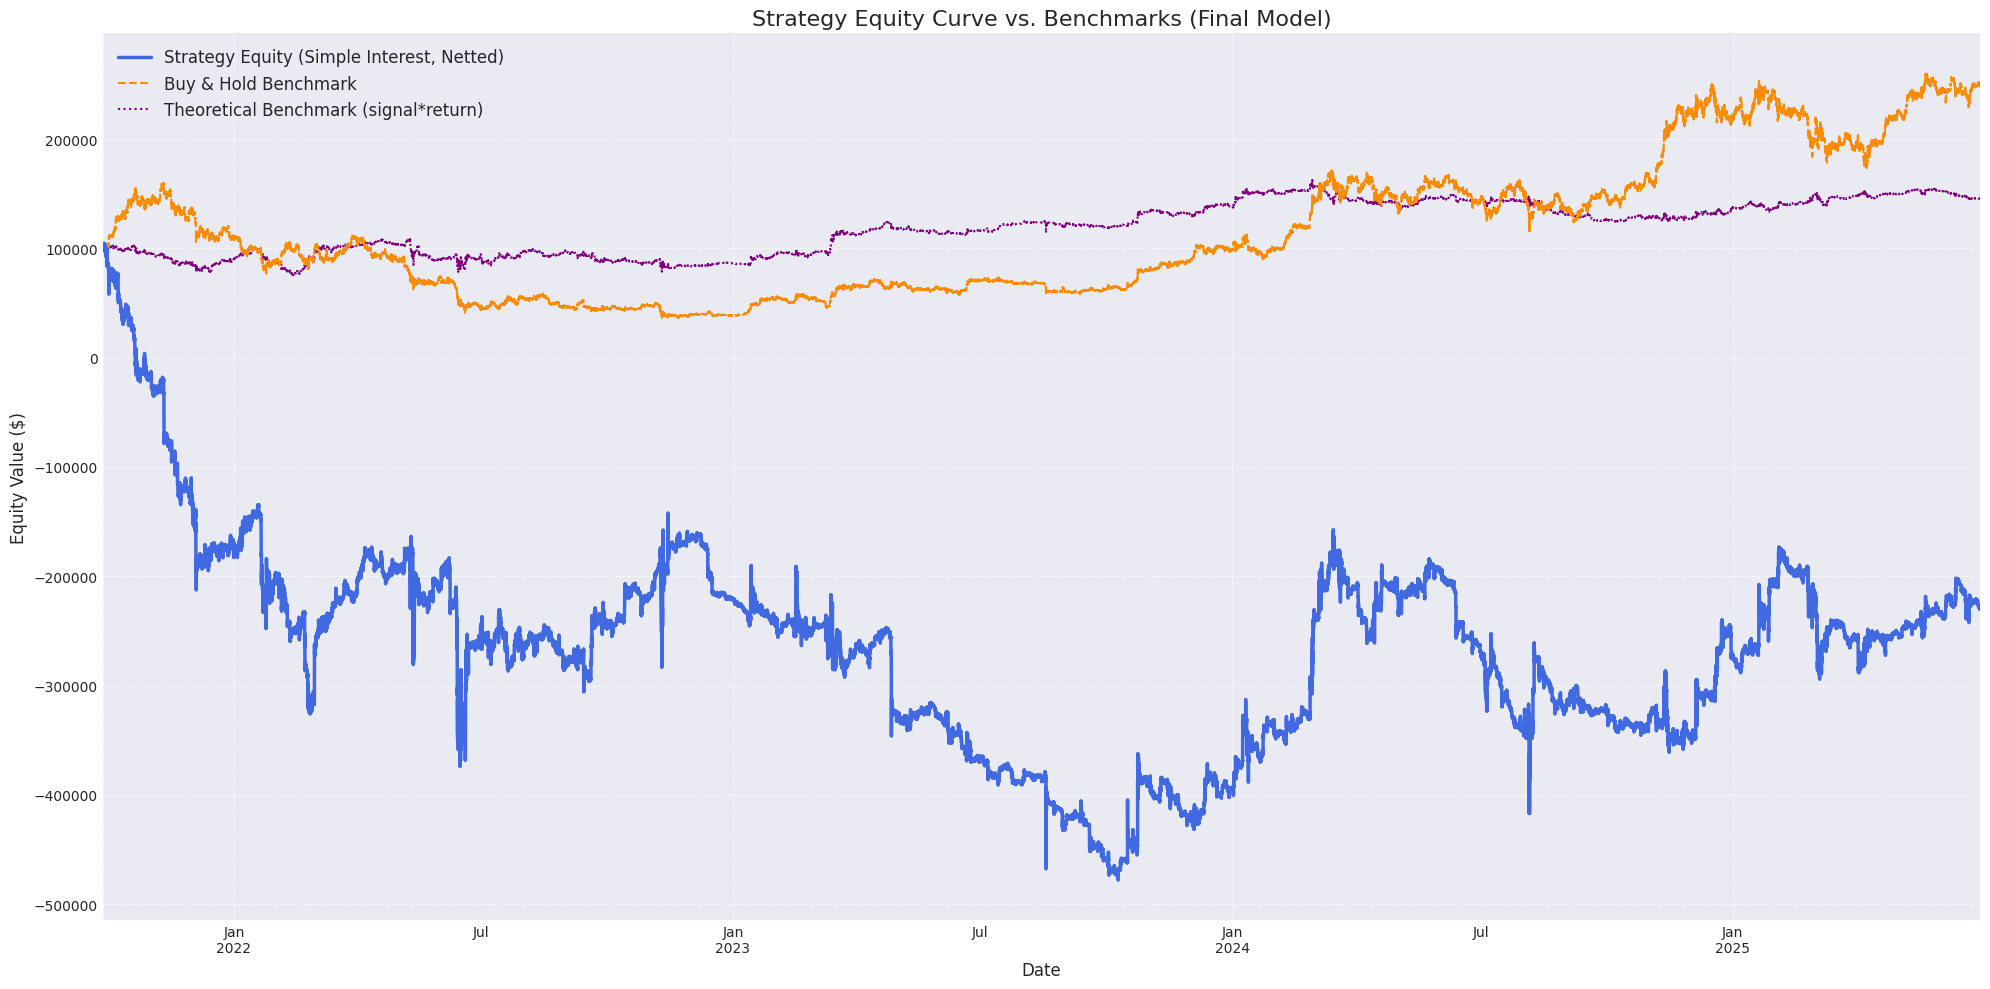

2025-07-24 16:52:52,104 - INFO - 🎊🎊🎊 策略评估完成 🎊🎊🎊


In [50]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # 确保索引是datetime类型
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')

        logging.info("数据加载成功。")
        print("数据预览:")
        print(data.head())
        print(f"\n数据时间范围: {data.index.min()} -> {data.index.max()}")
        print(f"数据形状: {data.shape}")

    except FileNotFoundError:
        logging.error(f"错误: 数据文件未找到于路径 {FILE_PATH}")
        data = None
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用最终版函数) ---
    if data is not None:
        backtest_results = run_vectorized_backtest_final(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )
        
        logging.info("回测结果 DataFrame (前5行):")
        print(backtest_results.head())
        
        logging.info("回测结果 DataFrame (后5行):")
        print(backtest_results.tail())

        # --- 4. 性能评估 ---
        evaluate_performance(
            backtest_results, 
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败，回测和评估步骤已跳过。")

In [52]:
df=data.copy()
ret=df['close'].shift(-10)/df['close']-1

In [53]:
sig=df['signal'].copy()

<Axes: xlabel='open_time'>

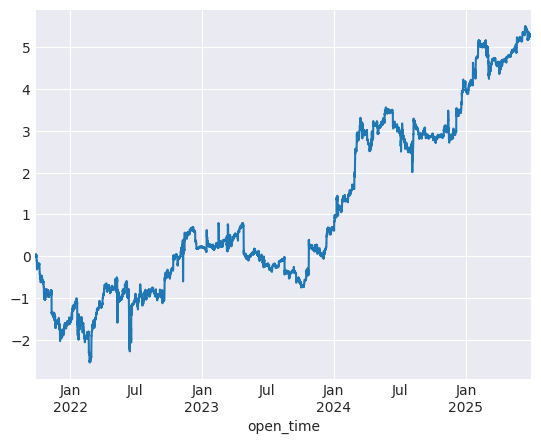

In [54]:
(sig*ret).cumsum().plot()

In [ ]:
temp=pd.DataFrame()
temp['signal'] = sig*1000
temp['return'] = ret
temp['true_return'] =0

In [ ]:
temp['true_return']=

,signal,return,true_return
open_time,,,
2021-09-27 00:00:00,0,0.024668,0
2021-09-27 00:15:00,0,0.025779,0
2021-09-27 00:30:00,0,0.015576,0
2021-09-27 00:45:00,0,0.004305,0
2021-09-27 01:00:00,0,0.001121,0
...,...,...,...
2025-06-30 22:45:00,0,NaN,0
2025-06-30 23:00:00,0,NaN,0
2025-06-30 23:15:00,0,NaN,0
